## Izing
модель Изинга (МИ)
https://ru.wikipedia.org/wiki/Модель_Изинга
https://farside.ph.utexas.edu/teaching/329/lectures/node110.html

Двумерная решеточная модель магнитных спинов $s$ со значениями $\pm{1}$ во внешнем поле $\vec {H}$ при температуре $kT$ и обменной константе $A_{ij}$, одна из моделей вычислительной физики, где есть фазовый переход 'магнитный порядок' <-> 'магнитный беспорядок'. Исторически применялась как простейшая модель ферромагнитного вещества в статистической физике. 
Чем хороша:
* есть температура $kT$
* есть 2 фазовых состояния - самоупорядочение при температуре ниже точки Кюри $T_c$ и хаос выше.
* есть близкодействие - в виде учета обменного взаимодействия соседних магнитных спинов через константу обменного взаимодействия $A_{обмен} $. 
* есть дальнодействие - в виде учета внешнего магнитного поля $\vec {H}$  
* Модель проста, но все описанные выше вещи разумно связываются воедино и интерпретируются. 
* Для модели есть точное аналитическое решение.

МИ обладает полезными обобщающими свойствами для многих систем. Например - https://zen.yandex.ru/media/the_world_is_not_easy/model-izinga-raskryvaet-tainu-sinhronnosti-prirodnyh-processov-5a7d74078651654f71129ef1 статья "Модель Изинга раскрывает тайну синхронности природных процессов". Также в моделировании лесных пожаров, теории 'разбитых окон' и прочих явлений биологии, социологии, экономики и подобного. 

Т.е. к величинам $kT$, $A_{обмен}$, $H$, $M$, $T_c$ можно подходить не как к конкретным количественным физическим величинам, а с обобщенных на описанные выше явления понятий.    



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from numba import njit,prange 
from numba import __version__ as numba_ver
import math
import sys
from tqdm import tqdm

print('numpy version '+np.__version__)
print('numba version '+numba_ver)

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (10,8)

numpy version 1.21.2
numba version 0.53.0


Определяем вероятность переворачивания спинов в решетке. Варианты - алгоритм Метрополиса и алгоритм тепловой бани. 

In [2]:
@njit
def test_Metropolis(E1,E2,kT):
    """ разыграть вероятность перехода E1->E2 для заданной kT. По алгоритму Метрополиса .
    True - переход делаем, False - не делаем """
    dE = E2-E1
    if dE<=0:
        return True
    W = np.exp(-dE/kT)
    p = np.random.random()
    if p<=W:
        return True
    return False   

@njit
def test_HeatBath(E1,E2,kT):
    """ разыграть вероятность перехода E1->E2 для заданной kT. По алгоритму тепловой ванны.
    True - переход делаем, False - не делаем """
    A = np.exp(-E2/kT)
    B = np.exp(-E1/kT)
    W = A/(A+B)
    p = np.random.random()
    if p<=W:
        return True
    return False   


#### CLattice2d - класс, реализующий модель Изинга. 

Размеры решетки $lattice$  XSIZE * YSIZE. 

$s_{ij}=lattice[i][j]$ 

Индексы $i=0..(XSIZE-1)$, $j=0..(YSIZE-1)$ 

Граничные условия - периодическое продолжение индексов, т.е. $lattice[-1][..]=lattice[XSIZE][..]$,  $lattice[..][-1]=lattice[..][YSIZE]$  

Каждый конкретный спин решетки $s_{ij}$ принимает только значения $+1$ или $-1$.

Внешнее поле $\vec {H}$ направлено вдоль оси $\vec {+1}$, поэтому рассматриваем только его амплитуду $H_{ext}=|\vec {H}|$

Общая намагниченность $M=\sum {s}$ 

Энергия отдельного спина $s_{ij}$ в решетке складывается из компонент:
* энеригия магнитного поля : $E_{внеш. поле}=s_{ij}*(Hext+M)$ 
* энергия обменная : $E_{обмен}$ = $-A_{обмен}$ * $\sum {s_{ij}*s_{mn}}$, где индексы $mn$ пробегают по 4 ближайшим соседним с $ij$ индексам за исключением их самих. 

Знак $'-'$ указывает, что минимум обменной энергии сиcтемы достигается, когда все спины ориентированы в одном направлении. Это нюанс, ибо иногда указывают саму константу $A_{обмен}$ отрицательной, и минус из выражения исчезает. Общепризнанной записи нет. Также $A_{обмен}$ иногда записывают в литературе как $A_{ij}$ или $J$. В модели Изинга $ij$ имеет значение индексов решетки, обменная константа постоянна по всей системе спинов, поэтому $A_{ij}$=$A_{обмен}$.

##### Итого - минимум энергии спина в магнитном поле - когда от ориентрирован против его направления. Минимум энергии обменного взаимодействия - когда спин сонаправлен с соседями.  Задавая температуру и внешнее поле, статистически разыгрывают направление спинов в решетке по алгоритму Метрополиса-Гастингса или алгоритму тепловой Бани.


При сравнениях принято общую энергию решетки делить на число спинов, т.к. это позволяет сравнивать решетки с разным числом спинов.




In [3]:
spinInverseCriteria= test_Metropolis # test_HeatBath #

@njit
def inverseSpin(lattice,i,j):
    """ перевернуть спин с индексом i,j."""
    if lattice[i,j]>0:
        lattice[i,j]=-1
        return -1
    else:
        lattice[i,j]=1
        return +1
    
@njit(fastmath=True)
def nearestSpinSumm(lattice,i,j,XSIZE,YSIZE):
    ip = (i+1)%XSIZE # индексы с периодическим продолжением
    im = (i-1+XSIZE)%XSIZE
    jp = (j+1)%YSIZE
    jm = (j-1+YSIZE)%YSIZE  
    # сумма спинов ближайших соседей, участвующих в обменном взаимодействии 
    NSpinSumm = lattice[i,jp]+lattice[i,jm]+lattice[im,j]+lattice[ip,j]      
    return NSpinSumm 

class CLattice2d():
    """ двумерная решетка Изинга """
    def __init__(self,XSIZE=50, YSIZE=50, Aij=1., Hext=0., kT=1.):
        """ размер X, размер Y, константа обменного взаимодействия, поле, температура """
        self.XSIZE = XSIZE
        self.YSIZE = YSIZE
        self.SPIN_CNT = self.XSIZE*self.YSIZE # число спинов в решетке
        self.lattice = np.ones(shape=(self.XSIZE,self.YSIZE))
        self.kT = kT # температура
        self.Aij = Aij # обменный параметр
        self.Hext = Hext # внешнее поле
        self.init_lattice()
        # величины, вычисляемые при выполнении shake_lattice() - встряхивании решетк 
        self.E = None # энергия
        self.Estd = None # дисперсия энергии
        self.M = None # намагниченность
        self.Mstd = None # дисперсия намагниченности 
        

    def init_lattice(self):
        """ инициализировать решетку """
        for _ in range(self.XSIZE): # инициализируем часть спинов в противоположную сторону
            i = np.random.randint(0,self.XSIZE)
            j = np.random.randint(0,self.YSIZE)
            inverseSpin(self.lattice,i,j)
    
    def shake_lattice(self,Ncount=2000):
        Adopt, E_,Estd_,M_,Mstd_ = CLattice2d._izing2d_shake_lattice(Ncount,self.Hext,self.lattice,self.Aij,self.kT)
        self.Adopt = Adopt
        self.E = E_
        self.Estd = Estd_
        self.M = M_
        self.Mstd = Mstd_ 
        return Adopt, E_,Estd_,M_,Mstd_

    @staticmethod
    @njit(fastmath=True)
    def _izing2d_shake_lattice(Ncount,Hext,spinLattice,Aij,kT):
        """ разыграть Ncount проходов по решетке"""
        XSIZE,YSIZE = spinLattice.shape
        SPIN_CNT = XSIZE*YSIZE
        spinSumm = np.sum(spinLattice)
        acceptedCount = 0
        E_arr = np.zeros(Ncount)
        M_arr = np.zeros(Ncount)
        
        
        for n_ in prange(Ncount):
            for i_ in range(XSIZE):
                for j_ in range(YSIZE):
                    # правило выбора индексов для лучшей сходимости
                    if n_%2==0: # слева направо, сверху вниз - быстрый рост доменов
                        i = i_
                        j = j_
                    else: # cлучайные - высокие температуры
                        i = np.random.randint(0,XSIZE)
                        j = np.random.randint(0,YSIZE)
        
                    NearestSpinSumm = nearestSpinSumm(spinLattice,i,j,XSIZE,YSIZE)

                    # вычисляем 
                    if spinLattice[i,j]>0: # пробуем переход '+1'->'-1'
                        M1 = spinSumm/SPIN_CNT 
                        E1 = -Aij*NearestSpinSumm-Hext*M1 # Энергия в состоянии '+1'
                        M2 = M1#(spinSumm-1)/SPIN_CNT  
                        E2 = Aij*NearestSpinSumm-Hext*M2 # Энергия в состоянии '-1'
                    else: # пробуем переход '-1'->'+1'
                        M1 = (spinSumm)/SPIN_CNT #-1.  
                        E1 = Aij*NearestSpinSumm-Hext*M1 # Энергия в состояниии '+1'
                        M2 = M1#(spinSumm+1)/SPIN_CNT #+1. 
                        E2 = -Aij*NearestSpinSumm-Hext*M2 # Энергия в состоянии '-1'

                    if spinInverseCriteria(E1,E2,kT):  
                        spinSumm += inverseSpin(spinLattice,i,j)
                        acceptedCount += 1 # коеффициент принятия
                        
            # тут вычисляем энергию и намагниченность определения ее среднего и дисперсии
            Eab_summ =0.
            for a in range(XSIZE):
                for b in range(YSIZE):
                    NearestSpinSumm = nearestSpinSumm(spinLattice,i,j,XSIZE,YSIZE)
                    E1 = spinLattice[i,j]*Aij*NearestSpinSumm # обменная энергия спина
                    Eab_summ += E1
            Echg = Eab_summ/(XSIZE*YSIZE)
            Ehm = np.mean(spinLattice)*Hext
            E_arr[n_] = Echg+Ehm
            M_arr[n_] = np.mean(spinLattice)
            
        # среднее и дисперсию считаем только по второй половине массива-когда все стабилизировалось
        E_1 = np.mean(E_arr[len(E_arr)//2:])
        Estd_1 = np.std(E_arr[len(E_arr)//2:])
        M_1 = np.mean(M_arr[len(M_arr)//2:])
        Mstd_1 = np.std(M_arr[len(M_arr)//2:])

        return acceptedCount/(XSIZE*YSIZE*Ncount), E_1,Estd_1,M_1,Mstd_1
    
    def calc_M(self):
        """ величина намагниченности """
        return np.mean(self.lattice)
    
    def calc_E(self):
        """ измерить полную энергию системы """
        return self.get_Exch()+self.get_Ehm() 
    
    def calc_Exch(self):
        """ измерить суммарную энергию обменного взаимодействия """
        return CLattice2d._calculate_Exch_summ(self.lattice,self.Aij)
    
    def calc_Ehm(self):
        """ энергия магнитного поля"""
        M1 = np.mean(self.lattice)
        return self.Hext*M1
    
    @staticmethod
    @njit(fastmath=True)
    def _calculate_Exch_summ(spinLattice,Aij):
        """ измерить обменную энергию системы, вернуть среднее """
        XSIZE,YSIZE = spinLattice.shape
        Exch_summ = 0.
        for i in prange(XSIZE):
            for j in prange(YSIZE):
                NearestSpinSumm = nearestSpinSumm(spinLattice,i,j,XSIZE,YSIZE)
                
                E1 = spinLattice[i,j]*Aij*NearestSpinSumm # обменная энергия спина
                Exch_summ += E1
        
        return Exch_summ/(XSIZE*YSIZE) 
                

temperature kT=0.01


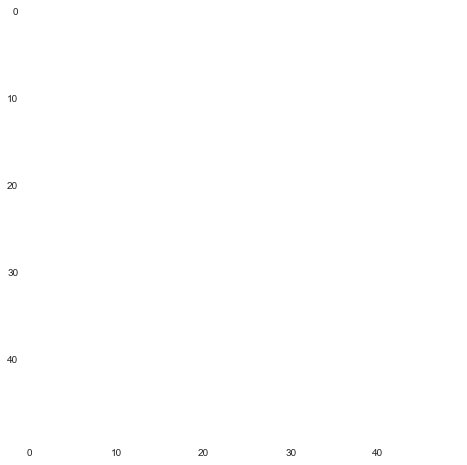

temperature kT=2.0


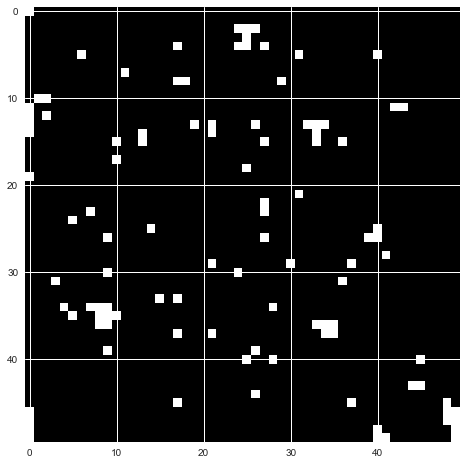

temperature kT=2.26


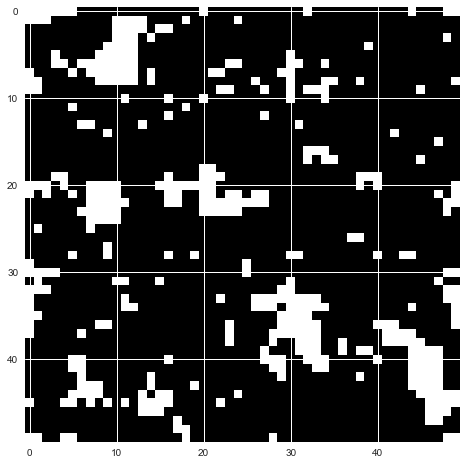

temperature kT=2.5


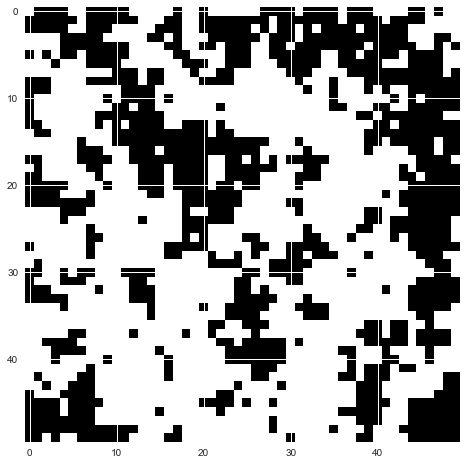

temperature kT=10


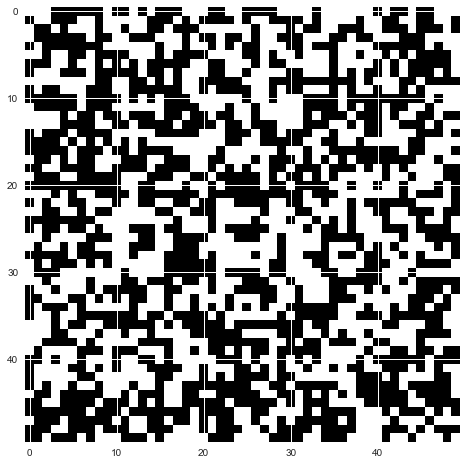

In [4]:
# визуализируем решетку
Izing = CLattice2d(kT=1e-2)
Izing.shake_lattice() 

for kT in [1e-2,2.0,2.26,2.5,10]:
    Izing.kT = kT
    Izing.shake_lattice()
    print('temperature kT='+str(kT))
    plt.imshow(Izing.lattice)
    plt.show()

### Построение графика спонтанной намагниченности

100%|████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


[]

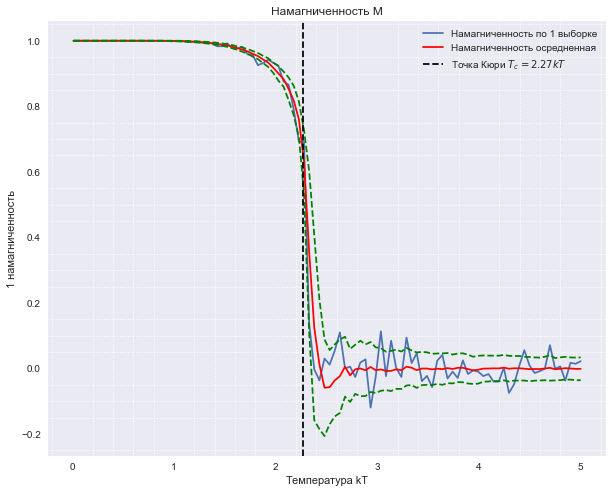

In [5]:
# график спонтанной намагниченности
kTarr = np.linspace(1e-2,5,100)
Izing = CLattice2d(kT=kTarr[0])
Izing.shake_lattice() 

Msample,Mmean,Mstd = [],[],[]

for kT in tqdm(kTarr):
    Izing.kT = kT
    Izing.shake_lattice()
    Msample.append(Izing.calc_M())
    Mmean.append(Izing.M)
    Mstd.append(Izing.Mstd)

plt.minorticks_on()
plt.title("Намагниченность M")
plt.xlabel('Температура kT')
plt.ylabel('1 намагниченность')
plt.grid()
plt.grid(which='minor',linestyle=':')
Mmean = np.array(Mmean)
Mstd = np.array(Mstd)


plt.plot(kTarr,Msample,label = 'Намагниченность по 1 выборке')
plt.plot(kTarr,Mmean,'r',label = 'Намагниченность осредненная')
plt.plot(kTarr,Mmean+Mstd,'g+',linestyle='dashed')
plt.plot(kTarr,Mmean-Mstd,'g+',linestyle='dashed')
plt.axvline(x=2.27, color='k', linestyle='--',label=r'Точка Кюри $T_c=2.27kT$')
plt.legend()
plt.plot()

График выше показывает, что при температуре около 2.27 энергетических единиц происходит скачкообразный переход намагниченности 

### Измерение теплоемкости

Для измерения теплоемкости МИ
используют уравнение статистической термодинамики
$C=\frac {\sigma^2_E} {kT^2}$

где $\sigma^2_E$ есть стандартная девиация энергии $E$

100%|████████████████████████████████████████| 100/100 [09:03<00:00,  5.43s/it]


[]

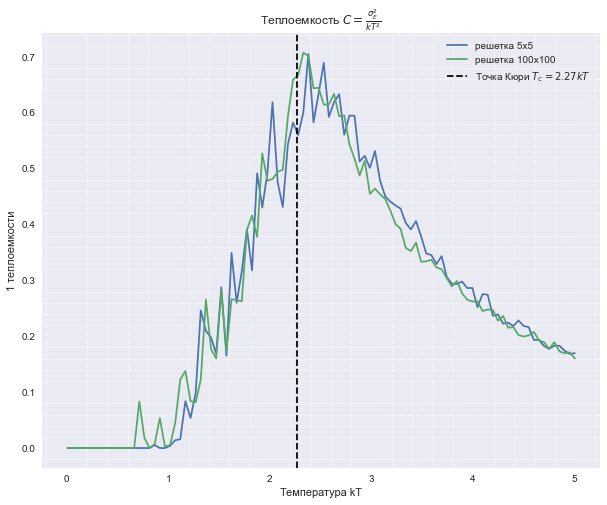

In [6]:
#%%script false

# вычисление теплоемкости
kTarr = np.linspace(1e-2,5,100)

Izing0 = CLattice2d(XSIZE=5,YSIZE=5,kT=kTarr[0])
Izing0.shake_lattice() 

Izing1 = CLattice2d(XSIZE=20,YSIZE=20,kT=kTarr[0])
Izing1.shake_lattice() 

Izing2 = CLattice2d(XSIZE=100,YSIZE=100,kT=kTarr[0])
Izing2.shake_lattice() 

C0,C1,C2 = [],[],[]

for kT in tqdm(kTarr):
    Izing0.kT = kT
    Izing0.shake_lattice(2000)
    Estd = Izing0.Estd
    C0.append((Estd**2)/(kT**2))
    
    Izing1.kT = kT
    Izing1.shake_lattice(3000)
    Estd = Izing1.Estd
    C1.append((Estd**2)/(kT**2))
    
    Izing2.kT = kT
    Izing2.shake_lattice(3000)
    Estd = Izing2.Estd
    C2.append((Estd**2)/(kT**2))

plt.minorticks_on()
plt.title(r"Теплоемкость $C=\frac {\sigma^2_E} {kT^2}$")
plt.xlabel('Температура kT')
plt.ylabel('1 теплоемкости')
plt.grid()
plt.grid(which='minor',linestyle=':')

plt.plot(kTarr,C0,label=r'решетка 5х5')
#plt.plot(kTarr,C1,label=r'решетка 20х20')
plt.plot(kTarr,C2,label=r'решетка 100х100')
plt.axvline(x=2.27, color='k', linestyle='--',label=r'Точка Кюри $T_c=2.27kT$')
plt.legend()
plt.plot()

Измерять теплоемкость по соотношению $C = \frac {\Delta E} {\Delta T}$ трудно, ибо энергия $E$ подвержена большому статистическому шуму.


100%|████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]


[]

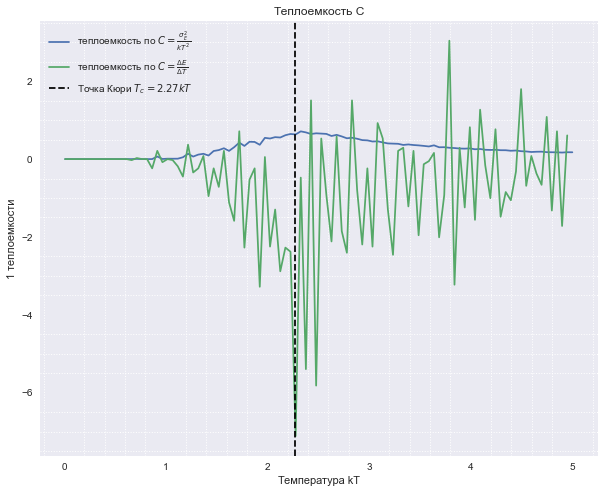

In [7]:
# вычисление теплоемкости

kTarr = np.linspace(1e-2,5,100)
Izing = CLattice2d(XSIZE=50,YSIZE=50,kT=kTarr[0])
Izing.shake_lattice() 

C = []
E = []

for kT in tqdm(kTarr):
    Izing.kT = kT
    Izing.shake_lattice(3000)
    E.append(Izing.E)
    Estd = Izing.Estd
    C.append((Estd**2)/(kT**2))
    
E = np.array(E)
dE = np.diff(E)
dkT = kTarr[1]-kTarr[0]
C2 = dE/dkT

plt.minorticks_on()
plt.title("Теплоемкость С")
plt.xlabel('Температура kT')
plt.ylabel('1 теплоемкости')
plt.grid()
plt.grid(which='minor',linestyle=':')

plt.plot(kTarr,C,label=r'теплоемкость по $C=\frac {\sigma^2_E} {kT^2}$')
plt.plot(kTarr[:len(C2)],C2,label = r'теплоемкость по $C = \frac {\Delta E} {\Delta T}$')
plt.axvline(x=2.27, color='k', linestyle='--',label=r'Точка Кюри $T_c=2.27kT$')

plt.legend()
plt.plot()


### Сравнение МИ с законом Кюри-Вейса

зависимость магнитной восприимчивости ферромагнетиков от температуры выше точки Кюри описывается законом Кюри-Вейса

https://ru.wikipedia.org/wiki/Закон_Кюри_—_Вейса

$\chi \sim \frac {1} {T-T_c}$ или $\chi = \frac {C} {T-T_c}$, где 

$C$- постоянная Кюри,

$\chi = \frac {M} {H}$ - магнитная восприимчивость

In [8]:
def CurieWeiss(T,Tc=2.27,C=1.):
    return C/(T-Tc)

100%|████████████████████████████████████████| 100/100 [04:14<00:00,  2.55s/it]


[]

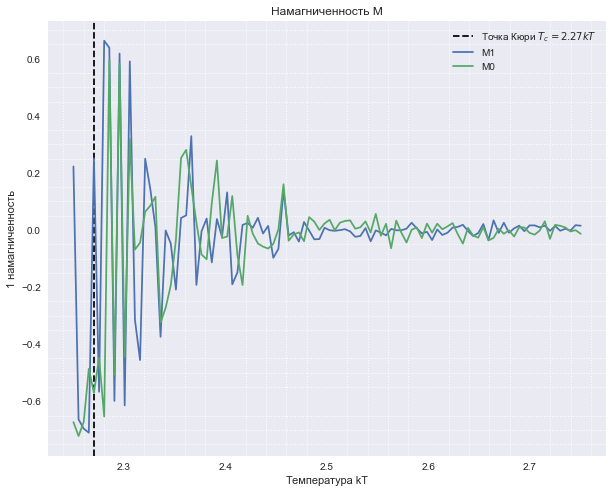

In [9]:
# график спонтанной намагниченности

kTarr = np.linspace(2.75,2.25,100)

H0 = -0.1
H1 = -10.
M0,M1 = [],[]

Izing0 = CLattice2d(kT=kTarr[0],Hext = H0)
Izing0.shake_lattice() 


for kT in tqdm(kTarr):
    Izing0.kT = kT
    Izing0.Hext = H0
    Izing0.shake_lattice(3000)
    M0.append(Izing0.M)
    Izing0.Hext = H1
    Izing0.shake_lattice(3000)
    M1.append(Izing0.M)

plt.minorticks_on()
plt.title("Намагниченность M")
plt.xlabel('Температура kT')
plt.ylabel('1 намагниченность')
plt.grid()
plt.grid(which='minor',linestyle=':')
M0 = np.array(M0)
M1 = np.array(M1)

plt.axvline(x=2.27, color='k', linestyle='--',label=r'Точка Кюри $T_c=2.27kT$')
plt.plot(kTarr,M1,label='M1')
plt.plot(kTarr,M0,label='M0')
plt.legend()
plt.plot()

Качество данных на графике на позволяет сравнение с законом Кюри-Вайса 